In [33]:
%reset -f

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import progressbar
import pandas as pd
%config InlineBackend.figure_format = 'retina'
from scipy.interpolate import interp1d
from scipy.stats import gamma
import math

In [35]:
class ArrivalProcess():
    def __init__(self, T, arrival_ls):
        self.arrival_ls = arrival_ls
        self.T = T
        self.n_arrival = len(arrival_ls)
    def run_through():
        return 1
    
    def set_service_time(self, service_ls):
        self.service_ls = service_ls
    
    def get_count_vector(self, interval_len):
        return np.histogram(self.arrival_ls, bins=np.arange(0, self.T + interval_len, interval_len))[0]
    
def get_CI(data_mat, n_std=2):
    mean_data = np.mean(data_mat,axis=0)
    std_data = np.std(data_mat, axis=0)
    return mean_data - n_std * std_data, mean_data + n_std * std_data


# CIR intensity

In [36]:
P = 22
interval_len = 0.5
T = P * interval_len

base_lam = np.array([124, 175, 239, 263, 285,
                 299, 292, 276, 249, 257,
                 274, 273, 268, 259, 251,
                 252, 244, 219, 176, 156,
                 135, 120])
x = np.linspace(interval_len/2, T-interval_len/2, len(base_lam))
y = base_lam
f2 = interp1d(x, y, kind='quadratic', fill_value='extrapolate')
def R_t(t):
    assert t >= 0
    assert t <= T
    return f2(t)
R_t = np.vectorize(R_t)

In [37]:
R_i = []
for i in range(P):
    interval_start = i * interval_len
    interval_end = (i + 1) * interval_len
    t_ls = np.arange(interval_start, interval_end, 0.002)
    r_ls = R_t(t_ls)
    R_i.append(np.mean(r_ls))
R_i = np.array(R_i)

$\mathrm{d} \lambda(t)=\kappa(R(t)-\lambda(t)) \mathrm{d} t+\sigma R(t)^{\alpha} \lambda(t)^{1 / 2} \mathrm{~d} B(t)$

In [8]:
# infinite server queue
# kappa = 0.2
# sigma = 0.4
# alpha = 0.3

# multi server queue
kappa = 3
# sigma = 0.4
sigma = 2
alpha = 0.3
        
# 计算 R(t) 在每个离散的仿真点上的数值，所有CIR都用这个
N = 5000
T_ls = np.linspace(0, T, N, endpoint=False)
R_t_on_T_ls = R_t(T_ls)
R_t_exp_alpha_on_T_ls = R_t_on_T_ls ** alpha
dt = T/N

def simulate_CIR():
    sqrt_dt = np.sqrt(dt)
    beta = 100
    B_t = np.random.normal(size=N)
    
    Z_t_0 = R_t_on_T_ls[0] * gamma.rvs(a=beta, scale=1/beta)
    Z_ls = np.zeros(N)
    Z_ls[0] = Z_t_0
    for i in range(N - 1):
        t = T_ls[i]
        Z_t = Z_ls[i]
        R_t_val = R_t_on_T_ls[i]
        R_t_exp_alpha_val = R_t_exp_alpha_on_T_ls[i]

        
        d_Z_t = kappa * (R_t_val - Z_t) * dt + sigma * R_t_exp_alpha_val * (Z_t**0.5) * sqrt_dt * B_t[i]
        Z_ls[i+1] = Z_t + d_Z_t
    return Z_ls

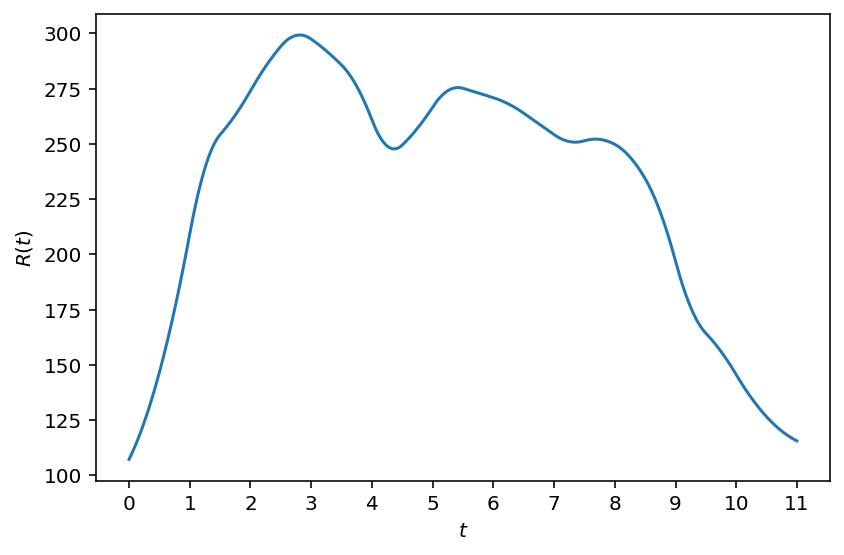

In [10]:
plt.figure(figsize=(6,4))
plt.plot(T_ls, R_t_on_T_ls)
plt.xlabel('$t$')
plt.xticks(np.arange(11.01))
plt.ylabel('$R(t)$')
plt.tight_layout()
# plt.savefig('figures/R_t.pdf')

# NHPP sampler for real CIR

In [11]:
def simulate_CIR_arrival():
    Z_ls = simulate_CIR()
    max_lam = np.max(Z_ls)
    N_arrival = np.random.poisson(max_lam * T)
    unfiltered_arrival_time = np.sort(np.random.uniform(0, T, size=N_arrival))

    keep_prob = np.array([Z_ls[int(t/dt)] for t in unfiltered_arrival_time])/max_lam
    whether_keep = np.random.rand(len(keep_prob)) <= keep_prob

    filtered_arrival_time = unfiltered_arrival_time[whether_keep]
    return filtered_arrival_time

In [12]:
# # get train CIR
# train_CIR_size = 300
# train_CIR_ls = np.ndarray((train_CIR_size,),dtype=np.object)
# train_count_mat = np.zeros((train_CIR_size, P))
# for i in progressbar.progressbar(range(train_CIR_size)):
#     train_CIR_ls[i] = ArrivalProcess(T=T,arrival_ls=simulate_CIR_arrival())
#     train_count_mat[i,:] = train_CIR_ls[i].get_count_vector(interval_len)

# np.save('tmp/data/cir_multi_server/training_set.npy', train_count_mat)

# get test CIR, just for illustration purpose
# test_CIR_size = 10000
# test_CIR_ls = np.ndarray((test_CIR_size,),dtype=np.object)
# test_count_mat = np.zeros((test_CIR_size, P))
# for i in progressbar.progressbar(range(test_CIR_size)):
#     test_CIR_ls[i] = ArrivalProcess(T=T,arrival_ls=simulate_CIR_arrival())
#     test_count_mat[i,:] = test_CIR_ls[i].get_count_vector(interval_len)

# np.save('tmp/data/cir_multi_server/test_set.npy', test_count_mat)

In [13]:
# max_arrival = 0
# get real CIR arrival process
real_CIR_size = 6000
real_CIR_ls = np.ndarray((real_CIR_size,),dtype=np.object)
real_count_mat = np.zeros((real_CIR_size, P))
for i in progressbar.progressbar(range(real_CIR_size)):
    real_CIR_ls[i] = ArrivalProcess(T=T,arrival_ls=simulate_CIR_arrival())
    real_count_mat[i,:] = real_CIR_ls[i].get_count_vector(interval_len)

    

/var/folders/7p/br8br_xs3yj51r8xsrl16ztc0000gn/T/ipykernel_48618/471070408.py:4: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  real_CIR_ls = np.ndarray((real_CIR_size,),dtype=np.object)
100% (6000 of 6000) |####################| Elapsed Time: 0:00:31 Time:  0:00:31


In [111]:
# _ = plt.plot(np.arange(0,11,0.5),real_count_mat.T/interval_len,c='k',alpha=0.05)
# plt.plot(T_ls, R_t_on_T_ls)
# %lprun -f simulate_CIR_arrival simulate_CIR_arrival()

# Arrival Epoch sampler

In [14]:
def arrival_epoch_sampler(count_vector):
    total_arrival = np.sum(count_vector)
    arrival_ls = np.zeros(total_arrival)
    index = 0
    for i in range(P):
        interval_start = i * interval_len
        interval_end = interval_start + interval_len
        arrival_ls_one_interval = np.random.uniform(interval_start, interval_end, size=count_vector[i])
        arrival_ls[index:index+count_vector[i]] = arrival_ls_one_interval
        index += count_vector[i]
    arrival_ls = np.sort(arrival_ls)
    return arrival_ls

In [113]:
# real_count_mat = real_count_mat.astype(int)
# real_PC_size = len(real_count_mat)
# real_PC_ls = np.ndarray((real_PC_size,),dtype=np.object)
# for i in progressbar.progressbar(range(real_PC_size)):
#     real_PC_ls[i] = ArrivalProcess(T=T,arrival_ls=arrival_epoch_sampler(real_count_mat[i,:]))
    

In [114]:
# %lprun -f arrival_epoch_sampler arrival_epoch_sampler()

# Infinite server queue

service_rate: 10.170976779079211


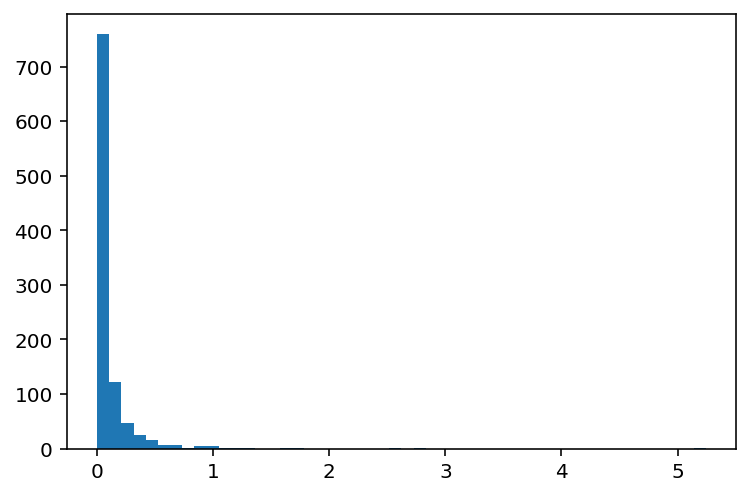

In [15]:

# lognormal distribution with 
# mean 206.44 and variance 23,667 (in seconds) as estimated from the data. Each waiting call
lognormal_var = 206.44/3600
lognormal_mean = 23667/3600**2
# lognormal_var = 0.1
# lognormal_mean = 0.1
lognormal_var = 0.1
lognormal_mean = 0.1
normal_sigma = (math.log(lognormal_var / lognormal_mean ** 2 + 1))**0.5
normal_mean = math.log(lognormal_mean) - normal_sigma ** 2 / 2

# service_rate = 1
# sampler = lambda size: np.random.exponential(1/service_rate, size=size)
sampler = lambda size: np.random.lognormal(mean=normal_mean,sigma=normal_sigma,size=size)

service_rate = 1/np.mean(sampler(1000))
print('service_rate:', service_rate)
# _ = plt.hist(sampler(1000),bins=50,range=(0,1))
_ = plt.hist(sampler(1000),bins=50)

In [16]:
def infinite_server_queue(arrival_ls, sampler, eval_t_ls):
    # calculate number of occupied servers at time t
    # given arrival time and service time for each customer
    service_ls = sampler(size=len(arrival_ls))
    if (type(eval_t_ls) is int) or (type(eval_t_ls) is float):
        eval_t_ls = np.array(eval_t_ls)
    end_ls = arrival_ls + service_ls
    return np.array([np.sum((end_ls >= t) & (arrival_ls <= t)) for t in eval_t_ls])


In [17]:
real_count_mat = real_count_mat.astype(int)
real_PC_size = len(real_count_mat)
real_PC_ls = np.ndarray((real_PC_size,),dtype=np.object)
for i in progressbar.progressbar(range(real_PC_size)):
    real_PC_ls[i] = ArrivalProcess(T=T,arrival_ls=arrival_epoch_sampler(real_count_mat[i,:]))

eval_t_ls = np.arange(0,11,0.05)
real_PC_n_occupied = np.zeros((real_PC_size, len(eval_t_ls)))
for i in progressbar.progressbar(range(real_PC_size)):
    real_PC_n_occupied[i,:] = infinite_server_queue(real_PC_ls[i].arrival_ls, sampler, eval_t_ls)
    

real_CIR_n_occupied = np.zeros((real_CIR_size, len(eval_t_ls)))
for i in progressbar.progressbar(range(real_CIR_size)):
    real_CIR_n_occupied[i,:] = infinite_server_queue(real_CIR_ls[i].arrival_ls, sampler, eval_t_ls)


/var/folders/7p/br8br_xs3yj51r8xsrl16ztc0000gn/T/ipykernel_48618/537584648.py:3: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  real_PC_ls = np.ndarray((real_PC_size,),dtype=np.object)
100% (6000 of 6000) |####################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (6000 of 6000) |####################| Elapsed Time: 0:00:12 Time:  0:00:12
100% (6000 of 6000) |####################| Elapsed Time: 0:00:12 Time:  0:00:12


In [118]:
# import ReadNetG
# DIR = 'cir_final'
# model_para = pd.read_csv('tmp/{}/model_para.csv'.format(DIR))
# print(len(model_para))
# model_para.drop_duplicates(subset=model_para.columns[1:],inplace=True)
# model_para.sort_values(['CRITIC_ITERS','DIM','GRADIENT_PENALTY','DROPOUT','OUTPUT','GENERATOR_PENALTY'],inplace=True)


In [119]:
# 用的是1607326660391008， gp=0.5 CRITIC_ITERS=10

In [18]:
# para = model_para.iloc[10]
# result_id = para['index']

# n_rep = 20
# fake_count_mat, _ = ReadNetG.generate_fake('tmp/cir_final/{}'.format(result_id),size=para['TRAIN_SIZE']*n_rep)


# fake_count_mat = fake_count_mat.astype(int)
# fake_PC_size = len(fake_count_mat)
# fake_PC_ls = np.ndarray((fake_PC_size,),dtype=np.object)
# for i in progressbar.progressbar(range(fake_PC_size)):
#     fake_PC_ls[i] = ArrivalProcess(T=T,arrival_ls=arrival_epoch_sampler(fake_count_mat[i,:]))

# fake_PC_n_occupied = np.zeros((fake_PC_size, len(eval_t_ls)))
# for i in progressbar.progressbar(range(fake_PC_size)):
#     fake_PC_n_occupied[i,:] = infinite_server_queue(fake_PC_ls[i].arrival_ls, sampler, eval_t_ls) 



# fake_n_occupied_mean_mat = np.zeros((n_rep, len(eval_t_ls)))
# fake_n_occupied_var_mat = np.zeros((n_rep, len(eval_t_ls)))
# for i in range(n_rep):
#     start_id = i * para['TRAIN_SIZE']
#     end_id = (i + 1) * para['TRAIN_SIZE']
#     fake_n_occupied_mean_one_rep = np.mean(fake_PC_n_occupied[start_id:end_id,:],axis=0)
#     fake_n_occupied_var_one_rep = np.var(fake_PC_n_occupied[start_id:end_id,:],axis=0)
#     fake_n_occupied_mean_mat[i,:] = fake_n_occupied_mean_one_rep
#     fake_n_occupied_var_mat[i,:] = fake_n_occupied_var_one_rep

# fake_mean_lb, fake_mean_ub = get_CI(fake_n_occupied_mean_mat)
# fake_var_lb, fake_var_ub = get_CI(fake_n_occupied_var_mat)


In [19]:
para = {}
para['TRAIN_SIZE'] = 300
n_rep = 20

In [20]:
fake_count_mat = real_count_mat
fake_PC_size = len(fake_count_mat)
fake_PC_ls = np.ndarray((fake_PC_size,),dtype=np.object)
for i in progressbar.progressbar(range(fake_PC_size)):
    fake_PC_ls[i] = ArrivalProcess(T=T,arrival_ls=arrival_epoch_sampler(fake_count_mat[i,:]))

fake_PC_n_occupied = np.zeros((fake_PC_size, len(eval_t_ls)))
for i in progressbar.progressbar(range(fake_PC_size)):
    fake_PC_n_occupied[i,:] = infinite_server_queue(fake_PC_ls[i].arrival_ls, sampler, eval_t_ls) 
    
fake_n_occupied_mean_mat = np.zeros((n_rep, len(eval_t_ls)))
fake_n_occupied_var_mat = np.zeros((n_rep, len(eval_t_ls)))

for i in range(n_rep):
    start_id = i * para['TRAIN_SIZE']
    end_id = (i + 1) * para['TRAIN_SIZE']
    fake_n_occupied_mean_one_rep = np.mean(fake_PC_n_occupied[start_id:end_id,:],axis=0)
    fake_n_occupied_var_one_rep = np.var(fake_PC_n_occupied[start_id:end_id,:],axis=0)
    fake_n_occupied_mean_mat[i,:] = fake_n_occupied_mean_one_rep
    fake_n_occupied_var_mat[i,:] = fake_n_occupied_var_one_rep

fake_mean_lb, fake_mean_ub = get_CI(fake_n_occupied_mean_mat)
fake_var_lb, fake_var_ub = get_CI(fake_n_occupied_var_mat)

/var/folders/7p/br8br_xs3yj51r8xsrl16ztc0000gn/T/ipykernel_48618/231156083.py:3: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fake_PC_ls = np.ndarray((fake_PC_size,),dtype=np.object)
100% (6000 of 6000) |####################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (6000 of 6000) |####################| Elapsed Time: 0:00:12 Time:  0:00:12


In [21]:
PC_rate = np.mean(real_count_mat,axis=0)
fix_PC_count_mat = np.random.poisson(PC_rate,size=(6000,len(PC_rate)))
fix_PC_size = len(fix_PC_count_mat)
fix_PC_ls = np.ndarray((fix_PC_size,),dtype=np.object)
for i in progressbar.progressbar(range(fix_PC_size)):
    fix_PC_ls[i] = ArrivalProcess(T=T,arrival_ls=arrival_epoch_sampler(fix_PC_count_mat[i,:]))

fix_PC_n_occupied = np.zeros((fix_PC_size, len(eval_t_ls)))
for i in progressbar.progressbar(range(fix_PC_size)):
    fix_PC_n_occupied[i,:] = infinite_server_queue(fix_PC_ls[i].arrival_ls, sampler, eval_t_ls) 
    
fix_n_occupied_mean_mat = np.zeros((n_rep, len(eval_t_ls)))
fix_n_occupied_var_mat = np.zeros((n_rep, len(eval_t_ls)))

for i in range(n_rep):
    start_id = i * para['TRAIN_SIZE']
    end_id = (i + 1) * para['TRAIN_SIZE']
    fix_n_occupied_mean_one_rep = np.mean(fix_PC_n_occupied[start_id:end_id,:],axis=0)
    fix_n_occupied_var_one_rep = np.var(fix_PC_n_occupied[start_id:end_id,:],axis=0)
    fix_n_occupied_mean_mat[i,:] = fix_n_occupied_mean_one_rep
    fix_n_occupied_var_mat[i,:] = fix_n_occupied_var_one_rep

fix_mean_lb, fix_mean_ub = get_CI(fix_n_occupied_mean_mat)
fix_var_lb, fix_var_ub = get_CI(fix_n_occupied_var_mat)

/var/folders/7p/br8br_xs3yj51r8xsrl16ztc0000gn/T/ipykernel_48618/242786467.py:4: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fix_PC_ls = np.ndarray((fix_PC_size,),dtype=np.object)
100% (6000 of 6000) |####################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (6000 of 6000) |####################| Elapsed Time: 0:00:12 Time:  0:00:12


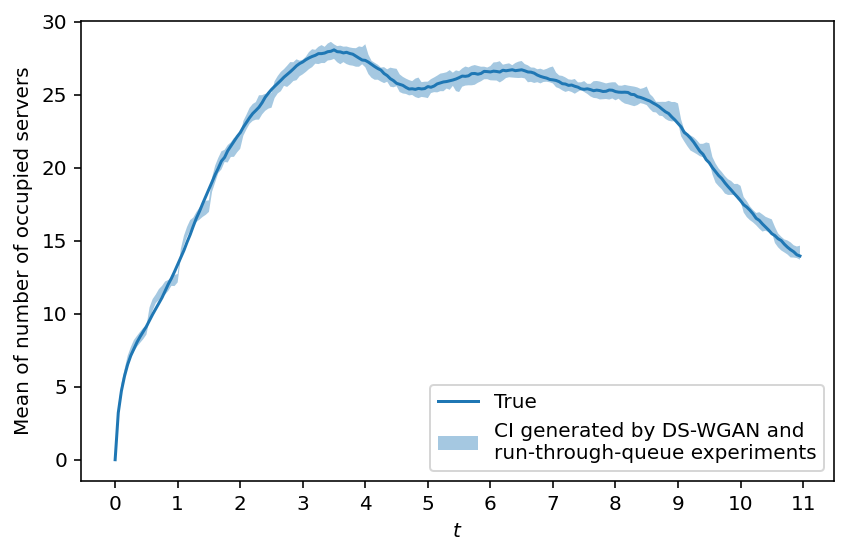

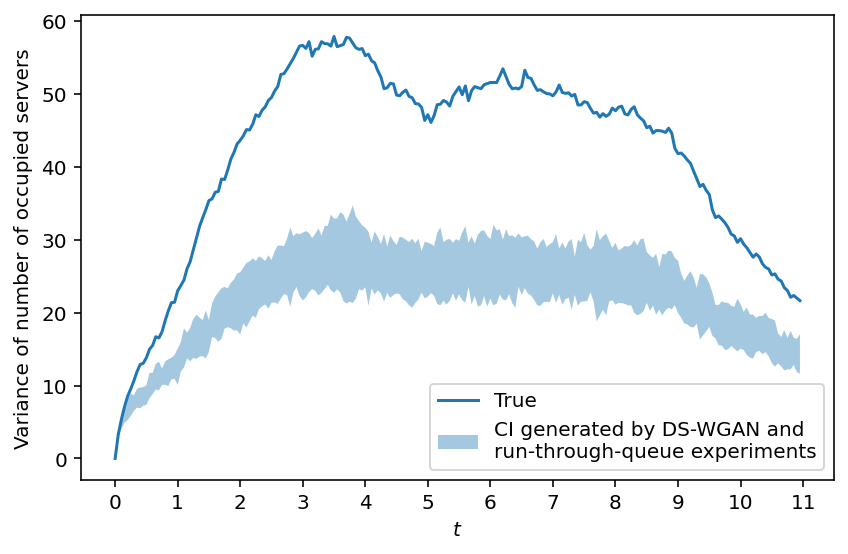

In [22]:
plt.figure(figsize=(6,4))

plt.plot(eval_t_ls, np.mean(real_CIR_n_occupied,axis=0),label='True')
plt.fill_between(eval_t_ls, fix_mean_lb, fix_mean_ub, alpha=0.4, label='CI generated by DS-WGAN and\nrun-through-queue experiments')
plt.xlabel('$t$')
plt.xticks(np.arange(11.01))
plt.ylabel('Mean of number of occupied servers')
plt.legend(loc='lower right')
plt.tight_layout()
# plt.savefig('figures/CIR_mean.pdf')

# plt.plot(eval_t_ls, np.mean(real_PC_n_occupied,axis=0),label='real PC')
plt.figure(figsize=(6,4))
plt.plot(eval_t_ls, np.var(real_CIR_n_occupied,axis=0),label='True')
plt.fill_between(eval_t_ls, fix_var_lb, fix_var_ub, alpha=0.4, label='CI generated by DS-WGAN and\nrun-through-queue experiments')
plt.xlabel('$t$')
plt.xticks(np.arange(11.01))
plt.ylabel('Variance of number of occupied servers')
# plt.plot(eval_t_ls, np.var(real_PC_n_occupied,axis=0),label='real PC')
plt.legend(loc='lower right')
plt.tight_layout()
# plt.savefig('figures/CIR_var.pdf')

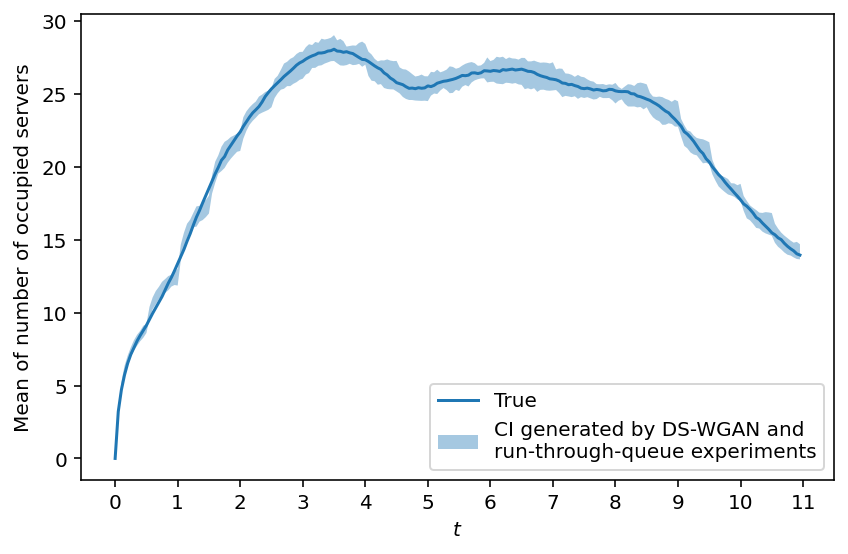

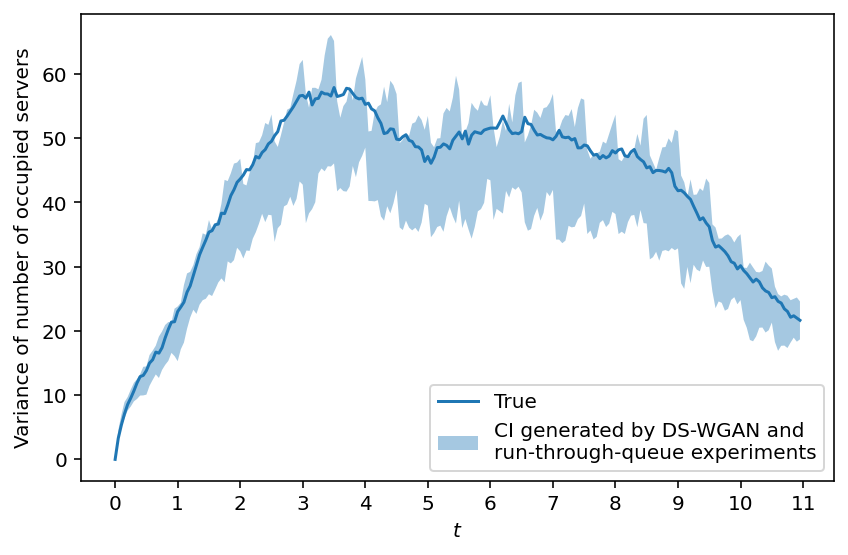

In [23]:
plt.figure(figsize=(6,4))

plt.plot(eval_t_ls, np.mean(real_CIR_n_occupied,axis=0),label='True')
plt.fill_between(eval_t_ls, fake_mean_lb, fake_mean_ub, alpha=0.4, label='CI generated by DS-WGAN and\nrun-through-queue experiments')
plt.xlabel('$t$')
plt.xticks(np.arange(11.01))
plt.ylabel('Mean of number of occupied servers')
plt.legend(loc='lower right')
plt.tight_layout()
# plt.savefig('figures/CIR_mean.pdf')

# plt.plot(eval_t_ls, np.mean(real_PC_n_occupied,axis=0),label='real PC')
plt.figure(figsize=(6,4))
plt.plot(eval_t_ls, np.var(real_CIR_n_occupied,axis=0),label='True')
plt.fill_between(eval_t_ls, fake_var_lb, fake_var_ub, alpha=0.4, label='CI generated by DS-WGAN and\nrun-through-queue experiments')
plt.xlabel('$t$')
plt.xticks(np.arange(11.01))
plt.ylabel('Variance of number of occupied servers')
# plt.plot(eval_t_ls, np.var(real_PC_n_occupied,axis=0),label='real PC')
plt.legend(loc='lower right')
plt.tight_layout()
# plt.savefig('figures/CIR_var.pdf')

# Multi server queue

service_rate: 5.167681322577404


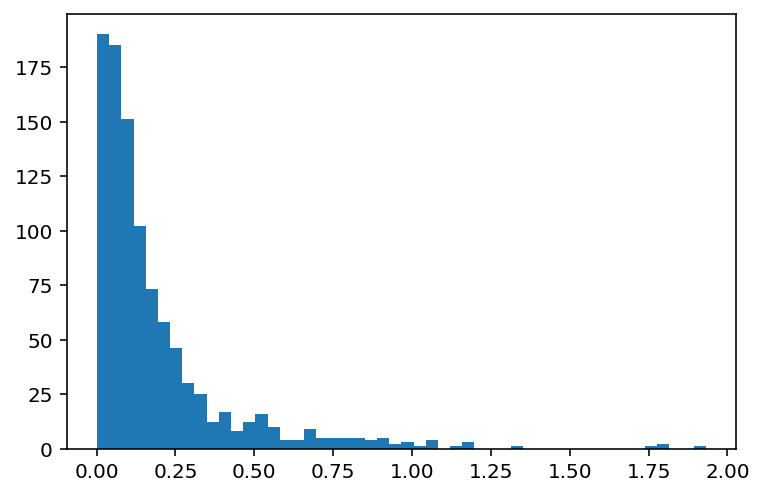

In [24]:

# lognormal distribution with 
# mean 206.44 and variance 23,667 (in seconds) as estimated from the data. Each waiting call
lognormal_var = 206.44/3600
lognormal_mean = 23667/3600**2
# lognormal_var = 0.1
# lognormal_mean = 0.1
lognormal_var = 0.1
lognormal_mean = 0.2
normal_sigma = (math.log(lognormal_var / lognormal_mean ** 2 + 1))**0.5
normal_mean = math.log(lognormal_mean) - normal_sigma ** 2 / 2

# service_rate = 1
# sampler = lambda size: np.random.exponential(1/service_rate, size=size)
sampler = lambda size: np.random.lognormal(mean=normal_mean,sigma=normal_sigma,size=size)

service_rate = 1/np.mean(sampler(1000))
print('service_rate:', service_rate)
# _ = plt.hist(sampler(1000),bins=50,range=(0,1))
_ = plt.hist(sampler(1000),bins=50)

In [25]:
# # assign service time for the arrival process
# for i in progressbar.progressbar(range(real_CIR_size)):
#     n_arrival = real_PC_ls[i].n_arrival
#     real_PC_ls[i].set_service_time(service_ls=sampler(n_arrival))
    
for i in progressbar.progressbar(range(real_CIR_size)):
    n_arrival = real_CIR_ls[i].n_arrival
    real_CIR_ls[i].set_service_time(service_ls=sampler(n_arrival))


100% (6000 of 6000) |####################| Elapsed Time: 0:00:00 Time:  0:00:00


In [26]:
arr_ser_df = pd.DataFrame(columns=['arrival_ls','service_ls','title','servers_config','beta','alpha'])

In [21]:
# id_beta_alpha_arr_ser_mat = - np.ones((30000, 3 + max_arrival * 2))
# import sys
# sys.getsizeof(id_beta_alpha_arr_ser_mat)

# def fill_to_length(arr, length):
#     result = np.concatenate([arr, - np.ones(length - len(arr))])
#     return result

# i = 0
# for arr_ser in real_CIR_ls:
#     id_beta_alpha_arr_ser_mat[i,0] = i
#     id_beta_alpha_arr_ser_mat[i,1] = beta
#     id_beta_alpha_arr_ser_mat[i,2] = alpha

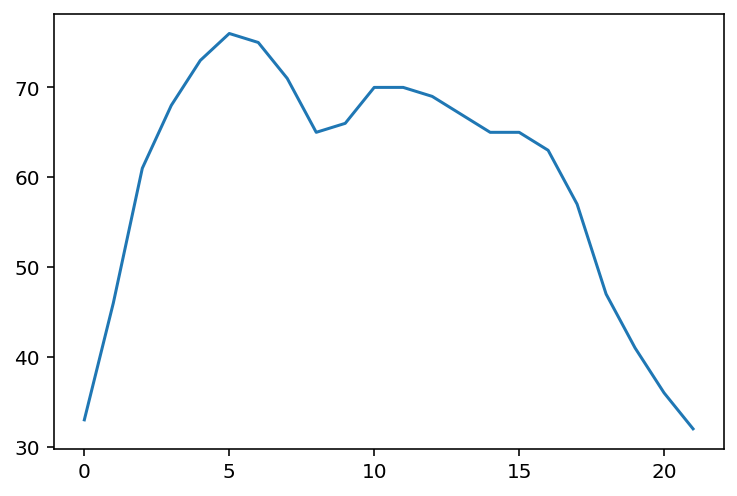

In [27]:
beta = 1 
alpha = 0.3 # 看下 alpha = 0 和 0.3 的差距多大
servers_config = np.round((R_i + beta * R_i ** (alpha + 0.5))/service_rate).astype(int)

plt.plot(servers_config)

In [23]:
# # arrival mat
# real_CIR_ls_mat = - np.ones((len(real_CIR_ls),max_arrival))
# for i in range(len(real_CIR_ls)):
#     real_CIR_ls_mat[i,:len(real_CIR_ls[i].arrival_ls)] = real_CIR_ls[i].arrival_ls
    
# real_PC_ls_mat = - np.ones((len(real_PC_ls),max_arrival))
# for i in range(len(real_PC_ls)):
#     real_PC_ls_mat[i,:len(real_PC_ls[i].arrival_ls)] = real_PC_ls[i].arrival_ls
    
# # service mat 
# real_CIR_serve_mat = - np.ones((len(real_CIR_ls),max_arrival))
# for i in range(len(real_CIR_ls)):
#     real_CIR_serve_mat[i,:len(real_CIR_ls[i].service_ls)] = real_CIR_ls[i].service_ls
    
# real_PC_serve_mat = - np.ones((len(real_PC_ls),max_arrival))
# for i in range(len(real_PC_ls)):
#     real_PC_serve_mat[i,:len(real_PC_ls[i].service_ls)] = real_PC_ls[i].service_ls

In [24]:
# arr_ser_dict = {}
# arr_ser_dict

In [28]:
# write arrival_ls and service_ls to file

for arr_ser in real_CIR_ls:
    arr_ser_df = arr_ser_df.append({'arrival_ls':arr_ser.arrival_ls,
                                    'service_ls':arr_ser.service_ls,
                                    'title':'real_CIR',
                                    'servers_config':servers_config,
                                    'beta':beta,
                                    'alpha':alpha}, ignore_index=True)
    
# for arr_ser in real_PC_ls:
#     arr_ser_df = arr_ser_df.append({'arrival_ls':arr_ser.arrival_ls,
#                                     'service_ls':arr_ser.service_ls,
#                                     'title':'real_PC',
#                                     'servers_config':servers_config,
#                                     'beta':beta,
#                                     'alpha':alpha}, ignore_index=True)
    
    

/var/folders/7p/br8br_xs3yj51r8xsrl16ztc0000gn/T/ipykernel_48618/987039418.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  arr_ser_df = arr_ser_df.append({'arrival_ls':arr_ser.arrival_ls,
/var/folders/7p/br8br_xs3yj51r8xsrl16ztc0000gn/T/ipykernel_48618/987039418.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  arr_ser_df = arr_ser_df.append({'arrival_ls':arr_ser.arrival_ls,
/var/folders/7p/br8br_xs3yj51r8xsrl16ztc0000gn/T/ipykernel_48618/987039418.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  arr_ser_df = arr_ser_df.append({'arrival_ls':arr_ser.arrival_ls,
/var/folders/7p/br8br_xs3yj51r8xsrl16ztc0000gn/T/ipykernel_48618/987039418.py:4: FutureWarning: The frame.append method is deprecated and will be removed fro

In [29]:
len(arr_ser_df)

6000

In [30]:
pd.to_pickle(arr_ser_df,'arr_ser_df')

# Turn to RunSimParallel Here

In [31]:
arr_ser_df = pd.read_pickle('arr_ser_df')

In [29]:
# for i in range(20):
#     print(i)
#     wait_time_result_part = pd.read_pickle('run_sim_result/wait_time_result_{}.pkl'.format(i))

In [233]:
# wait_time_result_part = pd.read_pickle('run_sim_result/wait_time_result_{}.pkl'.format(14))

In [234]:
1

1

In [32]:
wait_time_result = pd.DataFrame(columns=['arrival_ls','service_ls','title','servers_config','wait_ls'])

wait_time_result_ls = []
for i in range(20):
    print(i)
    wait_time_result_part = pd.read_pickle('run_sim_result/wait_time_result_{}.pkl'.format(i))
    wait_time_result_ls.append(wait_time_result_part)

0


FileNotFoundError: [Errno 2] No such file or directory: 'run_sim_result/wait_time_result_0.pkl'

In [236]:
wait_time_result = pd.concat(wait_time_result_ls)

wait_time_result = wait_time_result[~wait_time_result.index.duplicated(keep='first')]

In [237]:
import sys

sys.getsizeof(wait_time_result)

7330024

In [238]:
def get_wait_time_statistic_all_day(wait_time_ls, arrival_time_ls, statistic_interval):
#     print(wait_time_ls)
    # def get_wait_time_statistic_all_day(self, statistic_interval_sec, statistic='mean'):
    # statistic == mean or median
    # statistic_interval_sec: 多长的interval求一个统计量
    assert int(T / statistic_interval) == T / statistic_interval
    statistic = 'mean'
    n_interval = int(T/statistic_interval)
    wait_statistic_list = []
    for interval_id in range(n_interval):
        start_sec = interval_id * statistic_interval
        end_sec = start_sec + statistic_interval
        start_arrival_id = np.searchsorted(arrival_time_ls, start_sec)
        end_arrival_id = np.searchsorted(arrival_time_ls, end_sec)
    #     print(arrival_ls[start_arrival_id:end_arrival_id])
    #     print(start_sec, end_sec)
        wait_in_interval = wait_time_ls[start_arrival_id:end_arrival_id]
        if len(wait_in_interval) == 0:
            wait_statistic_list.append(0)
        elif statistic == 'mean':
            wait_statistic_list.append(np.mean(wait_in_interval))
    return np.array(wait_statistic_list)

In [239]:
wait_time_result['wait_summary'] = wait_time_result.apply(lambda x: get_wait_time_statistic_all_day(x.wait_ls, x.arrival_ls, statistic_interval=0.5),axis=1)


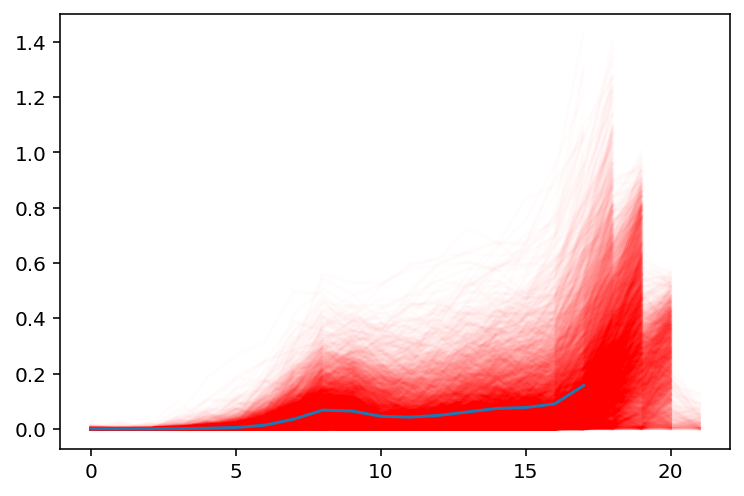

In [247]:
alpha = 0
wait_time_alpha_0_cir = wait_time_result[(wait_time_result['alpha']==alpha) & (wait_time_result['title']=='real_CIR')]
# wait_time_alpha_pc = wait_time_result[(wait_time_result['beta']==beta) & (wait_time_result['title']=='real_PC')]


alpha_0_cir_wait_summary_mat = np.stack(wait_time_alpha_0_cir.wait_summary.values)
# alpha_pc_wait_summary_mat = np.stack(wait_time_alpha_pc.wait_summary.values)

_ = plt.plot(alpha_0_cir_wait_summary_mat.T,alpha=0.01,c='r')
# _ = plt.plot(alpha_pc_wait_summary_mat.T,alpha=0.01,c='k')

plt.plot(np.mean(alpha_0_cir_wait_summary_mat,axis=0))
# plt.plot(np.mean(alpha_pc_wait_summary_mat,axis=0))

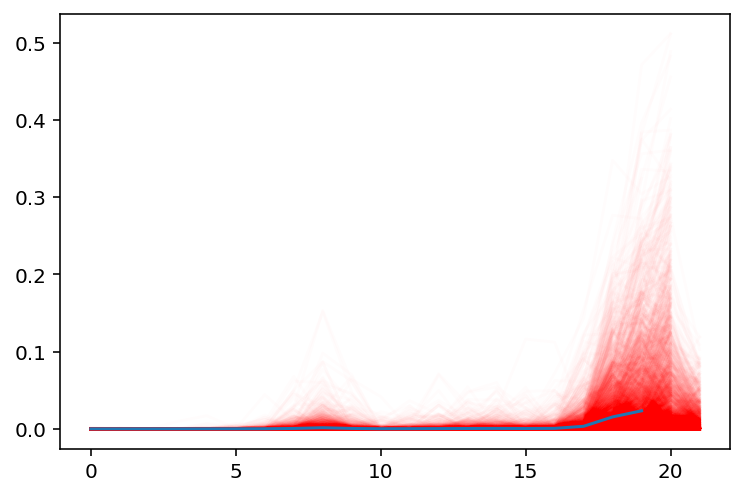

In [248]:
alpha = 0.3
wait_time_alpha_03_cir = wait_time_result[(wait_time_result['alpha']==alpha) & (wait_time_result['title']=='real_CIR')]
# wait_time_alpha_pc = wait_time_result[(wait_time_result['beta']==beta) & (wait_time_result['title']=='real_PC')]


alpha_03_cir_wait_summary_mat = np.stack(wait_time_alpha_03_cir.wait_summary.values)
# alpha_pc_wait_summary_mat = np.stack(wait_time_alpha_pc.wait_summary.values)

_ = plt.plot(alpha_03_cir_wait_summary_mat.T,alpha=0.01,c='r')
# _ = plt.plot(alpha_pc_wait_summary_mat.T,alpha=0.01,c='k')

plt.plot(np.mean(alpha_03_cir_wait_summary_mat,axis=0))
# plt.plot(np.mean(alpha_pc_wait_summary_mat,axis=0))

In [250]:
wait_time_alpha_03_cir

,arrival_ls,service_ls,title,servers_config,beta,alpha,wait_ls,wait_summary
5000,"[0.0351578536789483, 0.03650048456479715, 0.03...","[0.05222657239875625, 0.2389157624073842, 0.06...",real_CIR,"[34, 48, 63, 70, 75, 78, 77, 73, 67, 68, 72, 7...",1,0.3,"[0.0, 0.0, 0.0, 0.0, -1.3877787807814457e-17, ...","[3.560748187531341e-18, 4.611290252596575e-19,..."
5001,"[0.010040613332704784, 0.015225412497702262, 0...","[0.0728589608874968, 0.04183047040435795, 0.06...",real_CIR,"[34, 48, 63, 70, 75, 78, 77, 73, 67, 68, 72, 7...",1,0.3,"[0.0, 0.0, 0.0, -1.3877787807814457e-17, 0.0, ...","[3.5908775952719904e-18, -1.6829406856491413e-..."
5002,"[0.012739855292609237, 0.027985326832988933, 0...","[0.951140818311554, 0.36496344267902825, 0.028...",real_CIR,"[34, 48, 63, 70, 75, 78, 77, 73, 67, 68, 72, 7...",1,0.3,"[0.0, 0.0, 3.469446951953614e-18, 0.0, 1.38777...","[-3.7711379912539284e-19, -1.2432184911167118e..."
5003,"[0.007559684566115332, 0.011753230247255941, 0...","[0.1674077431896347, 0.16037865956011432, 0.03...",real_CIR,"[34, 48, 63, 70, 75, 78, 77, 73, 67, 68, 72, 7...",1,0.3,"[0.0, 0.0, 3.469446951953614e-18, 0.0, 0.0, 0....","[6.43293289008066e-18, -2.2551405187698493e-18..."
5004,"[0.011569479919576242, 0.01212249840387325, 0....","[0.03318315920089752, 0.06899947591042582, 0.0...",real_CIR,"[34, 48, 63, 70, 75, 78, 77, 73, 67, 68, 72, 7...",1,0.3,"[0.0, 0.0, -3.469446951953614e-18, 0.0, 1.3877...","[3.717264591378872e-18, 4.3762342234869455e-18..."
...,...,...,...,...,...,...,...,...
9995,"[0.028998372670569816, 0.03645862100800168, 0....","[0.24414382957685574, 0.007420680548859625, 0....",real_CIR,"[34, 48, 63, 70, 75, 78, 77, 73, 67, 68, 72, 7...",1,0.3,"[2.7755575615628914e-17, -1.734723475976807e-1...","[-1.4166908387143924e-18, -1.529295695926922e-..."
9996,"[0.0005616649878271707, 0.0016869246288870876,...","[0.1533670156576071, 0.12575490359768995, 0.06...",real_CIR,"[34, 48, 63, 70, 75, 78, 77, 73, 67, 68, 72, 7...",1,0.3,"[0.0, 0.0, 0.0, 0.0, 1.3877787807814457e-17, 0...","[-2.490167570353804e-18, -1.0000943675896593e-..."
9997,"[0.0061230787973580725, 0.010973490010486753, ...","[0.06007635263171405, 0.11839203586660826, 0.4...",real_CIR,"[34, 48, 63, 70, 75, 78, 77, 73, 67, 68, 72, 7...",1,0.3,"[-6.938893903907228e-18, 0.0, 0.0, 0.0, 0.0, 0...","[2.6655507069887524e-18, -1.6326809185664067e-..."
9998,"[0.009895860036890247, 0.01123677436007442, 0....","[0.07176344096424069, 0.2476271103649125, 0.03...",real_CIR,"[34, 48, 63, 70, 75, 78, 77, 73, 67, 68, 72, 7...",1,0.3,"[0.0, -2.7755575615628914e-17, 0.0, 0.0, 0.0, ...","[-1.9182038436282003e-18, -1.2034644114589099e..."


The history saving thread hit an unexpected error (OperationalError('database is locked',)).History will not be written to the database.


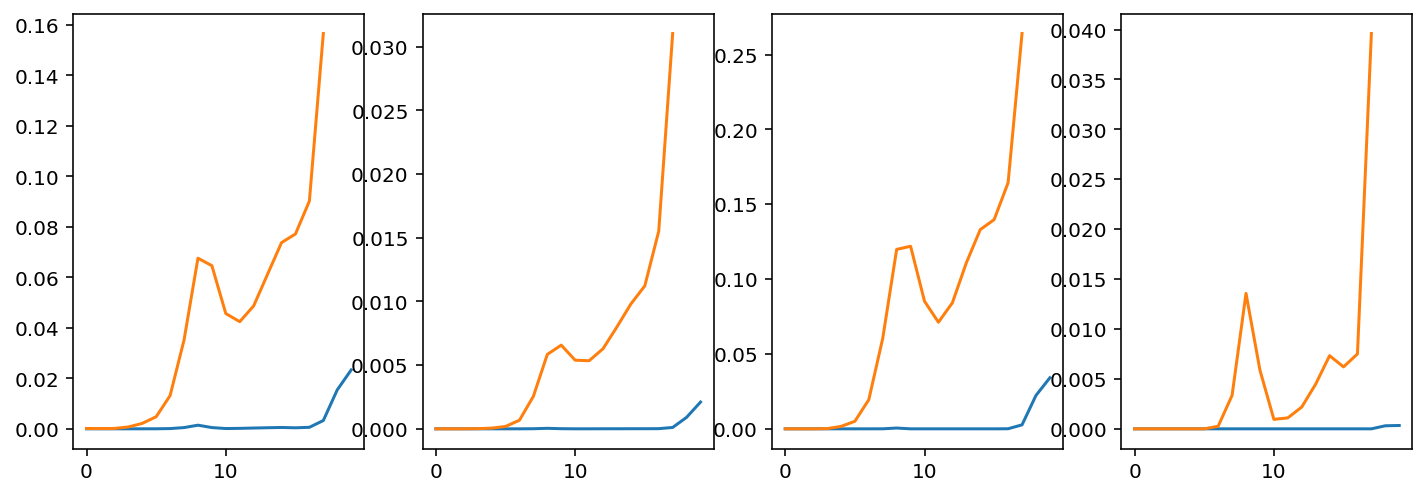

In [251]:
plt.figure(figsize=(12,4))
plt.subplot(141)
plt.plot(np.mean(alpha_03_cir_wait_summary_mat,axis=0))
plt.plot(np.mean(alpha_0_cir_wait_summary_mat,axis=0))
plt.subplot(142)
plt.plot(np.var(alpha_03_cir_wait_summary_mat,axis=0))
plt.plot(np.var(alpha_0_cir_wait_summary_mat,axis=0))
plt.subplot(143)
plt.plot(np.quantile(alpha_03_cir_wait_summary_mat,q=0.8,axis=0))
plt.plot(np.quantile(alpha_0_cir_wait_summary_mat,q=0.8,axis=0))
plt.subplot(144)
plt.plot(np.quantile(alpha_03_cir_wait_summary_mat,q=0.3,axis=0))
plt.plot(np.quantile(alpha_0_cir_wait_summary_mat,q=0.3,axis=0))

In [252]:
# beta_ls = [1,1.5,2]
# for i in range(3):
#     beta = beta_ls[i]
#     wait_time_part = wait_time_result[wait_time_result['beta'] == beta]
#     plt.plot(np.stack(wait_time_part.wait_summary.values).T,alpha=0.1,c='C'+str(i))

In [722]:
# real_count_mat = real_count_mat.astype(int)
# real_PC_size = len(real_count_mat)
# real_PC_ls = np.ndarray((real_PC_size,),dtype=np.object)
# # create piecewise constant arrivals
# for i in progressbar.progressbar(range(real_PC_size)):
#     real_PC_ls[i] = ArrivalProcess(T=T,arrival_ls=arrival_epoch_sampler(real_count_mat[i,:]))

# # compute wait time list
# for i in progressbar.progressbar(range(real_PC_size)):
#     real_PC_ls[i].wait_time_ls = multi_server_queue(real_PC_ls[i].arrival_ls, server_ls)

In [723]:
# # get wait time summary
# statistic_interval = 0.1
# real_PC_wait_mat = np.zeros((real_PC_size, int(T/statistic_interval)))
# for i in progressbar.progressbar(range(real_PC_size)):
#     real_PC_wait_mat[i,:] = get_wait_time_statistic_all_day(real_PC_ls[i].wait_time_ls,
#                                                             real_PC_ls[i].arrival_ls,
#                                                             statistic_interval=0.1) 

# # real_CIR_n_occupied = np.zeros((real_CIR_size, len(eval_t_ls)))
# # for i in progressbar.progressbar(range(real_CIR_size)):
# #     real_CIR_n_occupied[i,:] = infinite_server_queue(real_CIR_ls[i].arrival_ls, sampler, eval_t_ls)

Text(0.5, 1.0, 'beta:1.5  alpha: 0.3\n lognormal_var:0.1  lognormal_mean:0.2\nservice_rate:5.0')

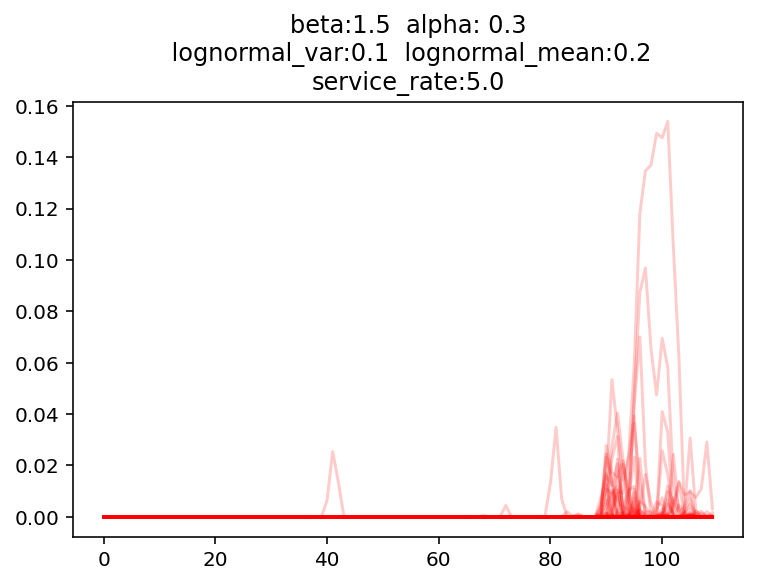

In [453]:
# _ = plt.plot(real_PC_wait_mat.T,c='r',alpha=0.2)
# plt.title('beta:{}  alpha: {}\n lognormal_var:{}  lognormal_mean:{}\nservice_rate:{}'.format(beta,
#                                                                                              alpha,
#                                                                                              lognormal_var,
#                                                                                              lognormal_mean,
#                                                                                              1/lognormal_mean))




In [455]:
# compute wait time list
for i in progressbar.progressbar(range(real_CIR_size)):
    real_CIR_ls[i].wait_time_ls = multi_server_queue(real_CIR_ls[i].arrival_ls, server_ls)

# get wait time summary
real_CIR_wait_mat = np.zeros((real_CIR_size, int(T/statistic_interval)))
for i in progressbar.progressbar(range(real_PC_size)):
    real_CIR_wait_mat[i,:] = get_wait_time_statistic_all_day(real_CIR_ls[i].wait_time_ls, real_CIR_ls[i].arrival_ls, statistic_interval=0.1) 
    

100% (100 of 100) |######################| Elapsed Time: 0:03:52 Time:  0:03:52
100% (100 of 100) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


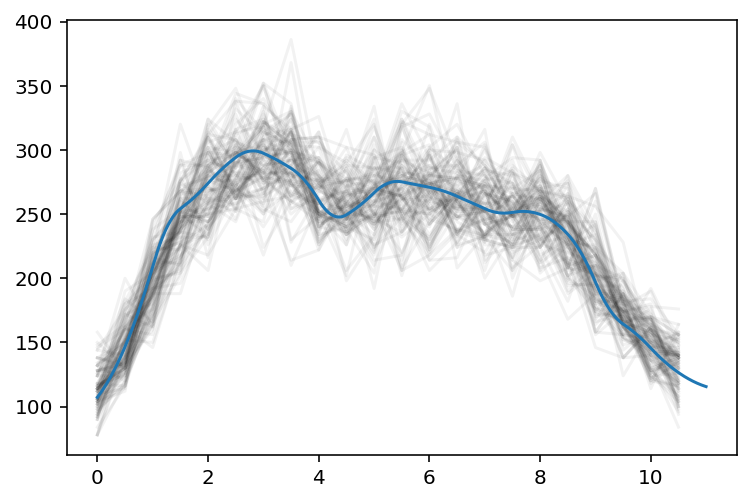

In [456]:
_ = plt.plot(np.arange(0,11,0.5),real_count_mat.T/interval_len,c='k',alpha=0.05)
plt.plot(T_ls, R_t_on_T_ls)

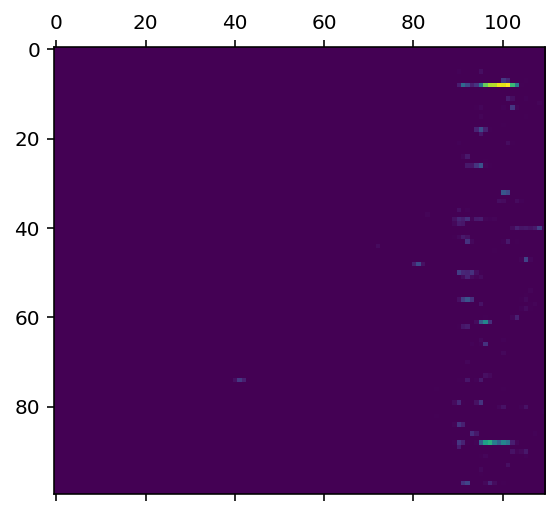

In [457]:
plt.matshow(real_PC_wait_mat)

In [275]:
# import ReadNetG
# DIR = 'cir_final'
# model_para = pd.read_csv('tmp/{}/model_para.csv'.format(DIR))
# print(len(model_para))
# model_para.drop_duplicates(subset=model_para.columns[1:],inplace=True)
# model_para.sort_values(['CRITIC_ITERS','DIM','GRADIENT_PENALTY','DROPOUT','OUTPUT','GENERATOR_PENALTY'],inplace=True)


# para = model_para.iloc[10]
# result_id = para['index']


# fake_count_mat, _ = ReadNetG.generate_fake('tmp/cir_final/{}'.format(result_id),size=100)



35


In [284]:
# fake_count_mat = fake_count_mat.astype(int)
# fake_PC_size = len(fake_count_mat)
# fake_PC_ls = np.ndarray((fake_PC_size,),dtype=np.object)
# # create piecewise constant arrivals
# for i in progressbar.progressbar(range(fake_PC_size)):
#     fake_PC_ls[i] = ArrivalProcess(T=T,arrival_ls=arrival_epoch_sampler(fake_count_mat[i,:]))

# # compute wait time list
# for i in progressbar.progressbar(range(fake_PC_size)):
#     fake_PC_ls[i].wait_time_ls = multi_server_queue(fake_PC_ls[i].arrival_ls, server_ls)

# # get wait time summary
# statistic_interval = 0.1
# fake_PC_wait_mat = np.zeros((fake_PC_size, int(T/statistic_interval)))
# for i in progressbar.progressbar(range(fake_PC_size)):
#     fake_PC_wait_mat[i,:] = get_wait_time_statistic_all_day(fake_PC_ls[i].wait_time_ls, statistic_interval=0.1) 
    

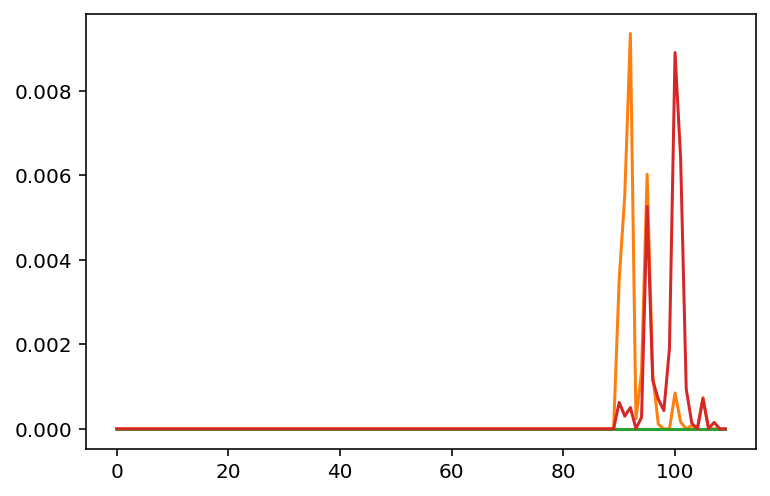

In [458]:
plt.plot(np.quantile(real_PC_wait_mat,q=0.1,axis=0))
plt.plot(np.quantile(real_PC_wait_mat,q=0.9,axis=0))


plt.plot(np.quantile(real_CIR_wait_mat,q=0.1,axis=0))
plt.plot(np.quantile(real_CIR_wait_mat,q=0.9,axis=0))

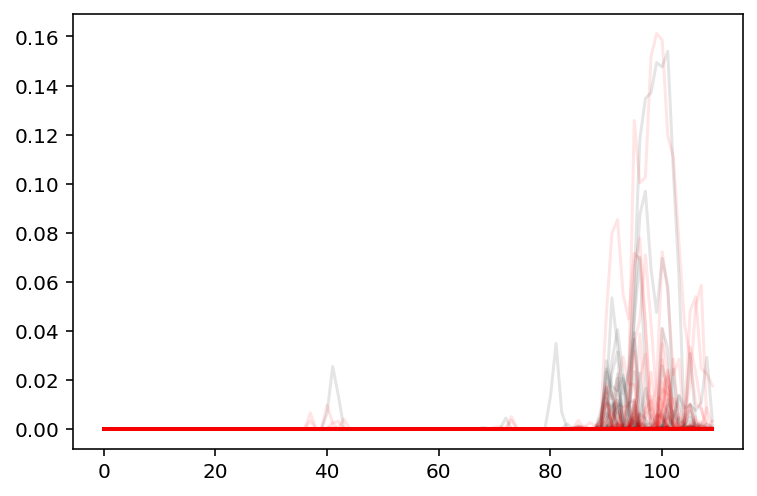

In [460]:
_ = plt.plot(real_PC_wait_mat.T,c='k',alpha=0.1)
_ = plt.plot(real_CIR_wait_mat.T,c='r',alpha=0.1)
# _ = plt.plot(fake_PC_wait_mat.T,c='g',alpha=0.1)
# plt.plot(np.mean(real_PC_wait_mat,axis=0))


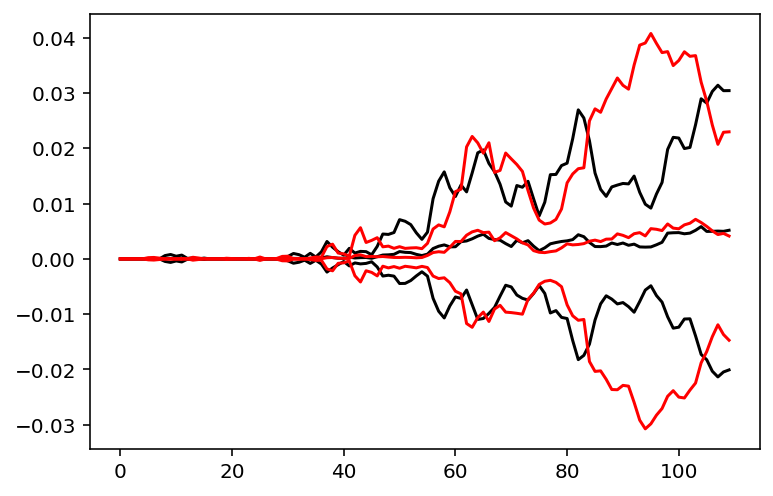

In [299]:
plt.plot(np.mean(real_PC_wait_mat,axis=0),c='k')
real_pc_lb, real_pc_ub = get_CI(real_PC_wait_mat,n_std=1)
plt.plot(real_pc_lb,c='k')
plt.plot(real_pc_ub,c='k')


plt.plot(np.mean(real_CIR_wait_mat,axis=0),c='r')
real_cir_lb, real_cir_ub = get_CI(real_CIR_wait_mat,n_std=1)
plt.plot(real_cir_lb,c='r')
plt.plot(real_cir_ub,c='r')
